# CHAPTER 2 - The Tools of the Trade in Quantum Computing - Qiskit Code

*Note*: You may skip the following two cells if you have alredy installed the right versions of all the libraries mentioned in *Appendix D*. This will likely NOT be the case if you are running this notebook on a cloud service such as Google Colab.

In [ ]:
pip install qiskit==0.39.2

In [ ]:
pip install pylatexenc==2.10

In [1]:
from qiskit import *

In [2]:
qreg1 = QuantumRegister(size = 2, name = "qrg1") #2 qubits
qreg2 = QuantumRegister(1, "qrg2")
creg = ClassicalRegister(1, "oldschool") #1 bit

qc = QuantumCircuit(qreg1, creg, qreg2)

In [3]:
qc.draw()

qrg1_0: 
             
     qrg1_1: 
             
       qrg2: 
             
oldschool: 1/

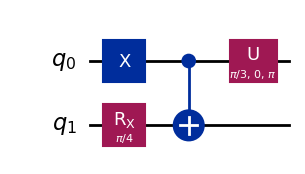

In [4]:
import numpy as np

qc = QuantumCircuit(2) # Initialise the circuit.

# We can now apply the gates sequentially.
qc.x(0)
qc.rx(np.pi/4, 1)
qc.cx(0, 1)
qc.u(np.pi/3, 0, np.pi, 0)

qc.draw("mpl")

In [6]:
from qiskit_aer  import AerSimulator

In [7]:
sim = AerSimulator()
sim_GPU = AerSimulator(device = 'GPU')

In [ ]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.measure(range(2), range(2)) #measure qubits 0 and 1 into bits 0 and 1

job = sim.run(qc, shots=1024) #execute(qc, sim, shots = 1024) execute is deprecated
result = job.result()
counts = result.get_counts()
print(counts)

{'01': 514, '00': 510}


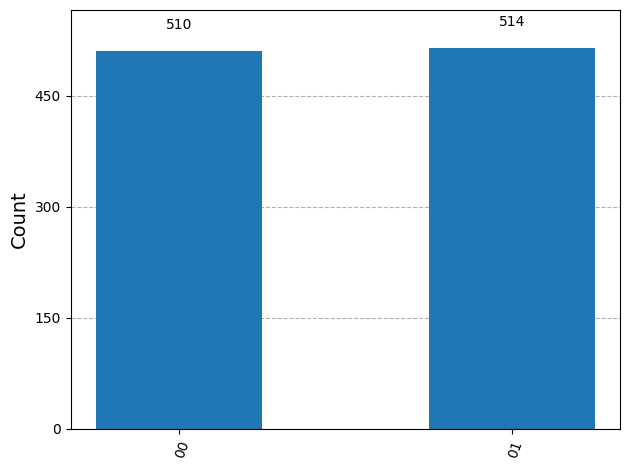

In [10]:
from qiskit.visualization import *
plot_histogram(counts)

In [13]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.save_statevector()
qc.measure(0,0)
qc.measure(1,1)

result = sim.run(qc, shots = 1024).result()
sv = result.get_statevector()
print(sv)
counts = result.get_counts()
print(counts)

Statevector([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))
{'01': 519, '00': 505}


In [ ]:
sim_u = AerSimulator(method = 'unitary') # Simulator to get the unitary matrix

qc = QuantumCircuit(1)
qc.h(0)
qc.save_unitary()

result = sim_u.run(qc).result()
U = result.get_unitary(decimals = 4)
print(U)

Operator([[ 0.7071+0.j,  0.7071-0.j],
          [ 0.7071+0.j, -0.7071+0.j]],
         input_dims=(2,), output_dims=(2,))


*Note*: In the following cell, you need to replace "1234" with your actual IBM token. Refer to *Appendix D* in the book for instructions on how to create an account and get your token. Be very careful not to disclose your token to anyone!

In [19]:
import os
ibm_token = os.getenv("IBM_QUANTUM_TOKEN")

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService


QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=ibm_token,
    overwrite=True,
    set_as_default=True,
)

# Load saved credentials
provider = QiskitRuntimeService()

qiskit_runtime_service.__init__:WARNING:2026-01-25 12:36:24,696: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [22]:
print(provider.backends(simulator = False))

qiskit_runtime_service.backends:WARNING:2026-01-25 12:36:26,977: Loading instance: open-instance, plan: open


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]


In [26]:
dev_list = provider.backends(
    filters = lambda x: x.configuration().n_qubits >= 5,
    simulator = False) #list of devices with at least 5 qubits

print(dev_list)

qiskit_runtime_service.backends:WARNING:2026-01-25 12:37:38,818: Loading instance: open-instance, plan: open


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]


In [ ]:
dev = min(dev_list, key=lambda b: b.status().pending_jobs)
print("Scelto:", dev.name, "pending_jobs:", dev.status().pending_jobs) #get the one with the least pending jobs

Scelto: ibm_marrakesh pending_jobs: 0


In [ ]:
# Let us set up a simple circuit.
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

# First, we run the circuit using the statevector simulator.
sim = AerSimulator()
result = sim.run(qc, shots = 1024).result()
counts_sim = result.get_counts()

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
# Now we run it on the real device that we selected before.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=5)
# transpile "ISA" per quel backend (consigliato da IBM)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1) 
isa_qc = pm.run(qc)

# esecuzione con Primitive SamplerV2
sampler = Sampler(mode=backend) 
job = sampler.run([isa_qc], shots=1024)

result = job.result()
counts = result[0].data.meas.get_counts()
print("Backend:", backend.name)
print(counts)

qiskit_runtime_service.__init__:WARNING:2026-01-25 12:47:21,722: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-25 12:47:22,224: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-25 12:47:24,582: Using instance: open-instance, plan: open


Backend: ibm_fez
{'11': 459, '00': 501, '01': 22, '10': 42}


In [34]:
print(counts_sim)
print(counts)

{'11': 497, '00': 527}
{'11': 459, '00': 501, '01': 22, '10': 42}
